# T2 - Fourier Methods

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def imshow(im, gray=False):
    plt.axis('off')
    if gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    plt.show()

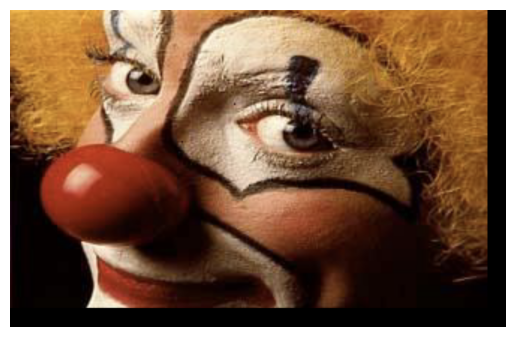

In [4]:
img = cv2.imread('image.png')

def img_preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    float32_img = np.float32(img / 255.0)

    h, w, c = float32_img.shape

    optimal_rows = cv2.getOptimalDFTSize(h)
    optimal_cols = cv2.getOptimalDFTSize(w)
    padded_img = cv2.copyMakeBorder(float32_img, 
                            0, optimal_rows - h,
                            0, optimal_cols - w,
                            cv2.BORDER_CONSTANT, value=0)
    return padded_img
    return float32_img

img = img_preprocess(img)
plt.axis('off')
_ = plt.imshow(img)

In [5]:
def cv2_dft_channel(ch):
    # Perform DFT
    dft = cv2.dft(ch, flags=cv2.DFT_COMPLEX_OUTPUT)
    # Shift DFT to center
    dft_shift = np.fft.fftshift(dft)
    # Return [R, I]
    return dft, dft_shift

def cv2_dft_img(img):
    # Split channels
    ch1, ch2, ch3 = cv2.split(img)
    # Perform DFT on each channel
    dft1, dft_shift1 = cv2_dft_channel(ch1)
    dft2, dft_shift2 = cv2_dft_channel(ch2)
    dft3, dft_shift3 = cv2_dft_channel(ch3)
    return np.array([dft1, dft2, dft3]), np.array([dft_shift1, dft_shift2, dft_shift3])

In [6]:
dft, dft_shift = cv2_dft_img(img)

In [7]:
def np_mv_0_to_neg1(arr):
    return np.moveaxis(arr, 0, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


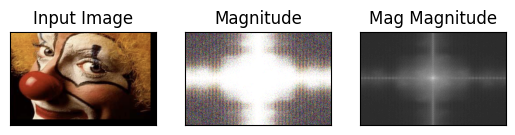

In [8]:
def cv2_magitude(dft_img):
    return np.array(
        [
            cv2.magnitude(dft_img[i,:,:,0], dft_img[i,:,:,1])
            for i in range(dft_img.shape[0])
        ])
def sum_magnitude(magitude_img):
    return np.sum(20*np.log(magitude_img), axis=0)

mag = cv2_magitude(dft_shift)

magnitude_spectrum = 20*np.log(mag)

sum_mag = sum_magnitude(mag)

plt.subplot(131),plt.imshow(img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(np_mv_0_to_neg1(magnitude_spectrum))
plt.title('Magnitude'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(sum_mag, cmap='gray')
plt.title('Mag Magnitude'), plt.xticks([]), plt.yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


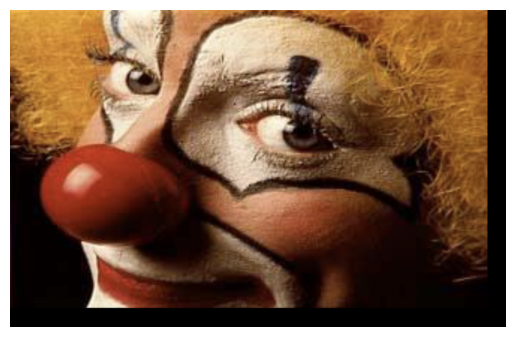

In [9]:
def cv2_idft_channel(ch):
    # Shift DFT to normal
    dft = np.fft.ifftshift(ch)
    # Perform IDFT
    ch_back = cv2.idft(dft, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    return ch_back

def cv2_dft_img_idf(dft_img):
    """3 x H x W x 2 -> H x W x 3"""
    idf = np.array([cv2_idft_channel(dft_img[i]) for i in range(dft_img.shape[0])])
    return np_mv_0_to_neg1(idf)

idf_img = cv2_dft_img_idf(dft_shift)
imshow(idf_img)

In [10]:
def viz_three_img(orig, dft, idft):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(orig)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(dft, cmap='gray')
    axs[1].set_title('Mag')
    axs[1].axis('off')
    axs[2].imshow(idft)
    axs[2].set_title('IDFT Image')
    axs[2].axis('off')
    plt.show()

def viz_four_img(orig, mg, dft, idft):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(orig)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(mg, cmap='gray')
    axs[1].set_title('Mag')
    axs[1].axis('off')
    axs[2].imshow(dft, cmap='gray')
    axs[2].set_title('Mag')
    axs[2].axis('off')
    axs[3].imshow(idft)
    axs[3].set_title('IDFT Image')
    axs[3].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


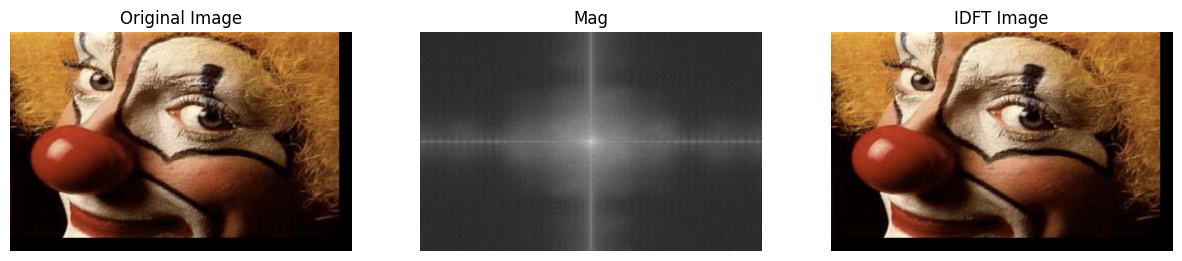

In [11]:
viz_three_img(img, sum_mag, idf_img)

In [12]:
def create_low_pass_filter(width, height, cutoff_frequency):
    rows, cols = np.mgrid[0:height, 0:width]
    center_x, center_y = width // 2, height // 2
    radius = np.sqrt((rows - center_y)**2 + (cols - center_x)**2)
    radius = radius / radius.max()
    mask = radius <= cutoff_frequency
    return mask

def apply_low_pass_filter(idf_image, cutoff_frequency=0.2):
    channels, height, width, complex_dim = idf_image.shape
    assert complex_dim == 2, "Expected complex number representation (real, imaginary)"
    filter_mask = create_low_pass_filter(width, height, cutoff_frequency)
    filtered_image = np.zeros_like(idf_image)
    

    for c in range(channels):
        complex_channel = idf_image[c, :, :, 0] + 1j * idf_image[c, :, :, 1]
        # true -> 1, false -> max
        filter_mask = filter_mask.astype(np.float32)
        # Apply filter
        filtered_channel = complex_channel * filter_mask
        filtered_channel += 1 - filter_mask
        
        # Store real and imaginary parts
        filtered_image[c, :, :, 0] = np.real(filtered_channel)
        filtered_image[c, :, :, 1] = np.imag(filtered_channel)
    
    return filtered_image

In [13]:
def high_pass_radius(img, cutoff_frequency=0.3):
    height, width, _ = img.shape
    rows, cols = np.mgrid[0:height, 0:width]
    center_x, center_y = width // 2, height // 2
    radius = np.sqrt((rows - center_y)**2 + (cols - center_x)**2)
    radius = radius / radius.max()
    mask = radius >= cutoff_frequency
    mask = np.array([mask, mask])
    mask = np.moveaxis(mask, 0, -1)
    return mask.astype(np.float32)

/var/folders/gl/fdb2hp6d7g39741y8_4rfm3m0000gn/T/ipykernel_38713/3403292128.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(20*np.log(magitude_img), axis=0)
/var/folders/gl/fdb2hp6d7g39741y8_4rfm3m0000gn/T/ipykernel_38713/4017595809.py:14: RuntimeWarning: divide by zero encountered in log
  hp_magnitude_spectrum = np_mv_0_to_neg1(20*np.log(hp_mag))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


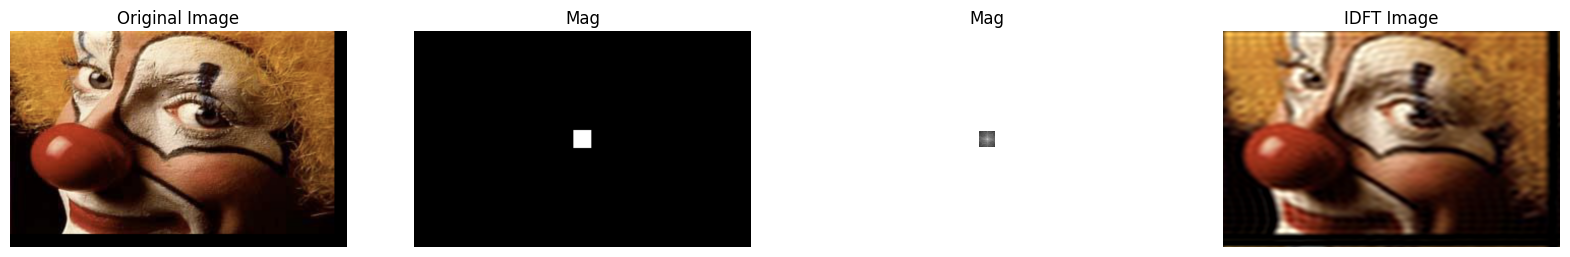

In [14]:
def high_pass_filter(img, cuttoff=30):
    h, w, _ = img.shape
    h_c,w_c = h//2 , w//2
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((h,w,2),np.uint8)
    mask[h_c-cuttoff:h_c+cuttoff, w_c-cuttoff:w_c+cuttoff] = 1
    return mask

hp_mask = high_pass_filter(img)
hp_fshift = dft_shift*hp_mask

hp_mag = cv2_magitude(hp_fshift)
hp_sum = sum_magnitude(hp_mag)
hp_magnitude_spectrum = np_mv_0_to_neg1(20*np.log(hp_mag))

hp_idf_img = cv2_dft_img_idf(hp_fshift)

viz_four_img(img, hp_magnitude_spectrum, hp_sum, hp_idf_img)


/var/folders/gl/fdb2hp6d7g39741y8_4rfm3m0000gn/T/ipykernel_38713/3403292128.py:8: RuntimeWarning: divide by zero encountered in log
  return np.sum(20*np.log(magitude_img), axis=0)
/var/folders/gl/fdb2hp6d7g39741y8_4rfm3m0000gn/T/ipykernel_38713/2050473308.py:14: RuntimeWarning: divide by zero encountered in log
  lp_magnitude_spectrum = 20*np.log(lp_mag)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


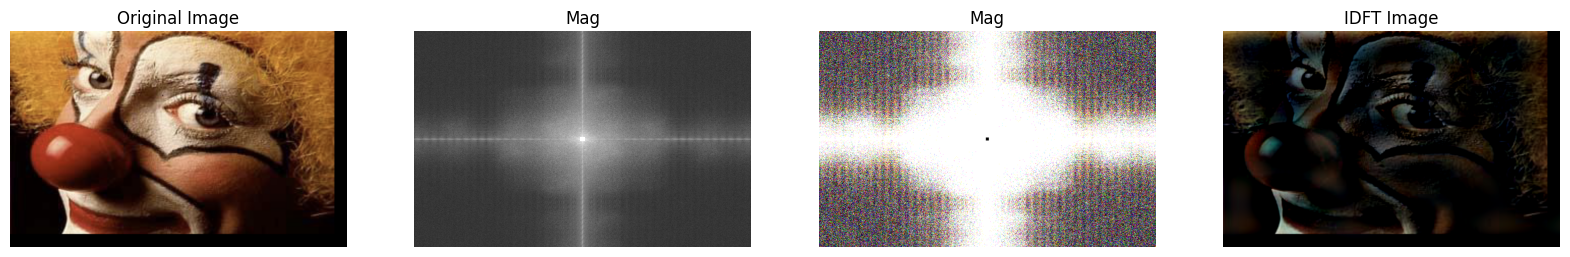

In [15]:
def low_pass_filter(img, cutoff=30):
    h, w, _ = img.shape
    h_c,w_c = h//2 , w//2
    # create a mask first, center square is 1, remaining all zeros
    mask = np.ones((h,w,2),np.uint8)
    mask[h_c-cutoff:h_c+cutoff, w_c-cutoff:w_c+cutoff] = 0
    return mask

lp_mask = low_pass_filter(img, 5)
lp_fshift = dft_shift*lp_mask

lp_mag = cv2_magitude(lp_fshift)
lp_sum = sum_magnitude(lp_mag)
lp_magnitude_spectrum = 20*np.log(lp_mag)

lp_idf_img = cv2_dft_img_idf(lp_fshift)

viz_four_img(img, lp_sum, np_mv_0_to_neg1(lp_magnitude_spectrum), lp_idf_img)
